# Definimos una clase para el algoritmo genético
### Inputs:
- pop_sz_0: Tamaño de la población inicial (Número de individuos que debe contener la población inicial)
- fit_fn: Función de fitness del algoritmo que permite asignar un valor a un individuo sobre la base de que tan bien cumple con el objetivo.
- cr_genes: Función para generar genes
- cr_indv: Función para generar individuos
- mut_rate: Tasa de mutación
- term_cond: Condición de terminación del algoritmo.


In [7]:
class GENALG(object):
    # Método inicializador para la clase algoritmo genético 

    def __init__(self, pop_sz_0: int, fit_fn, cr_genes, cr_indv, mut_rate, term_cond, indv_chars):
        # Verificamos que los parámetros de entrada del constructor sean los correctos
        if type(pop_sz_0) != int:
            raise ValueError("Input n_weights debe ser un número entero positivo")        
        self.__pop_sz = pop_sz_0
        self.__pop = None
        self.__pop_fitness = None
        self.__max_fitness = None
        self.__mean_fitness = None
        self.__min_fitness = None
        self.__fittest_indv = None
        self.__fit_fn = fit_fn
        self.__cr_genes = cr_genes
        self.__cr_indv = cr_indv
        self.__indv_chars = indv_chars
        self.__mut_rate = mut_rate
        self.__term_cond = term_cond

    # Métodos get para obtener los atributos del algoritmo genético.

    # Función para obtener el tamaño de la población
    def get_pop_sz(self):
        return self.__pop_sz
    
    # Función para obtener la población
    def get_pop(self):
        if self.__pop is None:
            raise ValueError("la población no ha sido creada")
        else:
            return self.__pop
    
    # Función para obtener la tasa de mutación
    def get_mut_rate(self):
        return self.__mut_rate
   
    # Función para obtener condición de terminación
    def get_term_cond(self):
        return self.__term_cond    

    # Función para obtener la función de fitness del algoritmo
    def get_fit_fn(self):
        return self.__fit_fn

    # Función para obtener la función de creación de genes del algoritmo
    def get_cr_genes(self):
        return self.__cr_genes
    
    # Función para obtener la función de creación de individuos del algoritmo
    def get_cr_indv(self):
        return self.__cr_indv    
           
            
    # Función para generar la población inicial
    def gen_pop(self):
        pop = {}
        for i in range(self.__pop_sz):
            pop[i] = self.__cr_indv(self.__cr_genes, indv_chars)
        self.__pop = pop

    def comp_pop_fitness(self, fit_params):   
        pop_fitness = {}
        max_fitness = -np.inf
        min_fitness = np.inf
        fittest_indv = None
        for i in range(self.__pop_sz):
            fitness = self.__fit_fn(self.__pop[i], fit_params)
            if fitness > max_fitness:
                max_fitness = fitness
                fittest_indv = self.__pop[i]
            if fitness < min_fitness:
                min_fitness = fitness
            pop_fitness[i] = fitness
        mean_fitness = np.mean(list(pop_fitness.values()))
        self.__pop_fitness = pop_fitness
        self.__max_fitness = max_fitness
        self.__min_fitness = min_fitness
        self.__mean_fitness = mean_fitness
        self.__fittest_indv = fittest_indv
    
    def tournament_sel(self, slots: int):
        if slots > self.__pop_sz:
            raise ValueError("slots debe ser un número entero positivo menor que el tamaño de la población")
        else:
            chosen_set = np.random.randint(0, self.__pop_sz, slots)
            chosen_set_fitness = [self.__pop_fitness[i] for i in chosen_set]
            max_set_fitness = max(chosen_set_fitness)        
            aux_dict = dict(zip(chosen_set_fitness, chosen_set))
            winner = aux_dict[max_set_fitness]
            return self.__pop[winner]
    
    def crossover(self, indv1, indv2):
        vals1 = list(indv1.values())
        vals2 = list(indv2.values())
        num_genes = len(vals1)
        cut = np.random.randint(1,num_genes)
        new_vals = vals1[:cut] + vals2[cut:]
        keys = list(indv1.keys())
        new_ind = dict(zip(keys, new_vals))
        return new_ind
    
    def mutation(self, indv):
        vals = list(indv.values())
        num_genes = len(vals)
        new_vals = []
        for i in range(num_genes):            
            if np.random.rand() > self.__mut_rate:
                new_vals.append(vals[i])
            else:
                cond = True
                while cond:
                    new_val = self.__cr_genes(self.__indv_chars[i]['gene_type'],self.__indv_chars[i]['fact_range'])
                    if new_val != vals[i]:
                        cond = False
                new_vals.append(new_val)
        keys = list(indv.keys())
        new_ind = dict(zip(keys, new_vals))
        return new_ind
    
    def apply(self,fit_params, slots, random_state=None):
        if type(random_state) == int:
            np.random.seed(random_state)
        self.gen_pop()
        self.comp_pop_fitness(fit_params)
        generations = {}        
        iters = 0
        goal_cross = 500
        overall_max_fitness = self.__max_fitness
        overall_fittest_indv = self.__fittest_indv
        generations[iters] = {}
        generations[iters]['max_fitness'] = self.__max_fitness
        generations[iters]['min_fitness'] = self.__min_fitness
        generations[iters]['mean_fitness'] = self.__mean_fitness
        if self.__max_fitness >= self.__term_cond['max_fitness'] and goal_cross == 500:
            goal_cross = iters
        while iters < self.__term_cond['iters']:
            new_pop = {}
            for i in range(self.__pop_sz):
                parent_1 = self.tournament_sel(slots)
                parent_2 = self.tournament_sel(slots)
                child = self.crossover(parent_1, parent_2)
                mut_child = self.mutation(child)
                new_pop[i] = mut_child
            self.__pop = new_pop.copy()
            self.comp_pop_fitness(fit_params)
            iters += 1
            generations[iters] = {}
            generations[iters]['max_fitness'] = self.__max_fitness
            generations[iters]['min_fitness'] = self.__min_fitness
            generations[iters]['mean_fitness'] = self.__mean_fitness
            if self.__max_fitness > overall_max_fitness:
                overall_max_fitness = self.__max_fitness
                overall_fittest_indv = self.__fittest_indv                
            if self.__max_fitness >= self.__term_cond['max_fitness'] and goal_cross == 500:
                goal_cross = iters
        return generations, goal_cross, overall_max_fitness, overall_fittest_indv
    
    

In [60]:
def gene_factory_ex1(gene_type, fact_range):
    if fact_range != [0,1] or gene_type != 'binary':
        raise ValueError("Parámetros incorrectos")
    else:
        gene = np.random.choice(fact_range)
        return gene

def indv_factory(gene_factory, indv_chars):    
    vals = list(indv_chars.values())
    num_genes = len(vals)
    new_indv = {}
    for i in range(num_genes):
        new_indv[i] = gene_factory(indv_chars[i]['gene_type'],indv_chars[i]['fact_range'])
    return new_indv

def fitness_ex1(indv, objective):
    vals = list(indv.values())
    vals_str = ''.join(str(i) for i in vals)
    fitness = abs(int(objective, 2)-int(vals_str, 2))
    return -fitness

In [73]:
# Prueba ejercicio 1
secuencia_bits = '00101010110101'
pop_sz_0 = 40
fit_fn = fitness_ex1 
cr_genes = gene_factory_ex1
cr_indv = indv_factory
mut_rate = 0.1
term_cond = {'max_fitness':0, 'iters':50} 
indv_chars = {}
for i in range(len(secuencia_bits)):
    aux_dict = {}
    aux_dict['gene_type'] = 'binary'
    aux_dict['fact_range'] = [0,1]
    indv_chars[i] = aux_dict.copy()

In [74]:
GA = GENALG(pop_sz_0, fit_fn, cr_genes, cr_indv, mut_rate, term_cond, indv_chars)

In [75]:
slots = 5
GA.apply(secuencia_bits,slots)

({0: {'max_fitness': -166, 'mean_fitness': -7516.575, 'min_fitness': -13344},
  1: {'max_fitness': -91, 'mean_fitness': -2969.2, 'min_fitness': -13501},
  2: {'max_fitness': -81, 'mean_fitness': -1128.625, 'min_fitness': -8345},
  3: {'max_fitness': -76, 'mean_fitness': -591.925, 'min_fitness': -8089},
  4: {'max_fitness': -76, 'mean_fitness': -666.5, 'min_fitness': -8272},
  5: {'max_fitness': -75, 'mean_fitness': -355.1, 'min_fitness': -4209},
  6: {'max_fitness': -75, 'mean_fitness': -1250.075, 'min_fitness': -12496},
  7: {'max_fitness': -75, 'mean_fitness': -917.625, 'min_fitness': -8270},
  8: {'max_fitness': -76, 'mean_fitness': -394.125, 'min_fitness': -3660},
  9: {'max_fitness': -75, 'mean_fitness': -742.175, 'min_fitness': -8331},
  10: {'max_fitness': -75, 'mean_fitness': -1374.6, 'min_fitness': -8300},
  11: {'max_fitness': -75, 'mean_fitness': -642.3, 'min_fitness': -8267},
  12: {'max_fitness': -75, 'mean_fitness': -528.95, 'min_fitness': -8331},
  13: {'max_fitness': -7

In [76]:
def gene_factory_ex2(gene_type, fact_range):
    if fact_range != list('abcdefghijklmnñopqrstuvwxyzABCDEFGHIJKLMNÑOPQRSTUVWXYZ ') or gene_type != str:
        raise ValueError("Parámetros incorrectos")
    else:
        gene = np.random.choice(fact_range)
        return gene
    
def fitness_ex2(indv, objective):
    vals = list(indv.values())
    obj = list(objective)
    hits =0
    for i in range(len(vals)):
        if vals[i] == obj[i]:
            hits += 1   
    return hits

In [81]:
# Prueba ejercicio 2
frase = 'helloworld'
pop_sz_0 = 40
fit_fn = fitness_ex2 
cr_genes = gene_factory_ex2
cr_indv = indv_factory
mut_rate = 0.2
term_cond = {'max_fitness':10, 'iters':70} 
indv_chars = {}
char_list = list('abcdefghijklmnñopqrstuvwxyzABCDEFGHIJKLMNÑOPQRSTUVWXYZ ')
for i in range(len(frase)):
    aux_dict = {}
    aux_dict['gene_type'] = str
    aux_dict['fact_range'] = char_list
    indv_chars[i] = aux_dict.copy()
GA = GENALG(pop_sz_0, fit_fn, cr_genes, cr_indv, mut_rate, term_cond, indv_chars)
slots = 5
GA.apply(frase,slots)

({0: {'max_fitness': 1, 'mean_fitness': 0.2, 'min_fitness': 0},
  1: {'max_fitness': 2, 'mean_fitness': 0.7, 'min_fitness': 0},
  2: {'max_fitness': 2, 'mean_fitness': 1.125, 'min_fitness': 0},
  3: {'max_fitness': 3, 'mean_fitness': 1.425, 'min_fitness': 0},
  4: {'max_fitness': 4, 'mean_fitness': 1.975, 'min_fitness': 1},
  5: {'max_fitness': 5, 'mean_fitness': 2.225, 'min_fitness': 0},
  6: {'max_fitness': 4, 'mean_fitness': 2.375, 'min_fitness': 0},
  7: {'max_fitness': 4, 'mean_fitness': 2.65, 'min_fitness': 1},
  8: {'max_fitness': 5, 'mean_fitness': 3.025, 'min_fitness': 1},
  9: {'max_fitness': 5, 'mean_fitness': 3.3, 'min_fitness': 1},
  10: {'max_fitness': 5, 'mean_fitness': 3.35, 'min_fitness': 1},
  11: {'max_fitness': 6, 'mean_fitness': 3.65, 'min_fitness': 1},
  12: {'max_fitness': 6, 'mean_fitness': 4.175, 'min_fitness': 2},
  13: {'max_fitness': 6, 'mean_fitness': 4.425, 'min_fitness': 2},
  14: {'max_fitness': 7, 'mean_fitness': 4.3, 'min_fitness': 2},
  15: {'max_fitn

In [8]:
def gene_factory_ex3(gene_type, fact_range):
    if fact_range != [0,15] or gene_type != int:
        raise ValueError("Parámetros incorrectos")
    else:
        gene = np.random.randint(fact_range[0], fact_range[1]+1)
        return gene
def indv_factory(gene_factory, indv_chars):    
    vals = list(indv_chars.values())
    num_genes = len(vals)
    new_indv = {}
    for i in range(num_genes):
        new_indv[i] = gene_factory(indv_chars[i]['gene_type'],indv_chars[i]['fact_range'])
    return new_indv    
def fitness_ex3(indv, objective):    
    vals = list(indv.values())
    pesos = objective['pesos']
    valores = objective['valores']
    fitness = np.dot(vals,valores)
    penalizacion = 0 
    peso_total = np.dot(vals,pesos)
    if peso_total > objective['capacidad']:
        penalizacion = objective['castigo']*(peso_total - objective['capacidad']) 
    fitness -= penalizacion
    return fitness

In [36]:
# Prueba ejercicio 3
pesos = [12,2,1,1,4]
valores = [4,2,2,1,10]
capacidad = 15
castigo = 15
fit_params ={'pesos':pesos, 'valores':valores, 'capacidad':capacidad, 'castigo':castigo}
pop_sz_0 = 40
fit_fn = fitness_ex3 
cr_genes = gene_factory_ex3
cr_indv = indv_factory
mut_rate = 0.2
term_cond = {'max_fitness':10, 'iters':70} 
indv_chars = {}
for i in range(len(pesos)):
    aux_dict = {}
    aux_dict['gene_type'] = int
    aux_dict['fact_range'] = [0,15]
    indv_chars[i] = aux_dict.copy()
GA = GENALG(pop_sz_0, fit_fn, cr_genes, cr_indv, mut_rate, term_cond, indv_chars)
slots=5
GA.apply(fit_params, slots)

({0: {'max_fitness': -523, 'mean_fitness': -1845.45, 'min_fitness': -3380},
  1: {'max_fitness': -161, 'mean_fitness': -1165.25, 'min_fitness': -3276},
  2: {'max_fitness': -161, 'mean_fitness': -805.225, 'min_fitness': -2163},
  3: {'max_fitness': 23, 'mean_fitness': -757.525, 'min_fitness': -2742},
  4: {'max_fitness': 13, 'mean_fitness': -445.45, 'min_fitness': -2618},
  5: {'max_fitness': 31, 'mean_fitness': -389.225, 'min_fitness': -2243},
  6: {'max_fitness': 33, 'mean_fitness': -301.725, 'min_fitness': -2063},
  7: {'max_fitness': 33, 'mean_fitness': -303.125, 'min_fitness': -2751},
  8: {'max_fitness': 33, 'mean_fitness': -366.85, 'min_fitness': -2513},
  9: {'max_fitness': 33, 'mean_fitness': -369.075, 'min_fitness': -2023},
  10: {'max_fitness': 31, 'mean_fitness': -353.075, 'min_fitness': -2537},
  11: {'max_fitness': 31, 'mean_fitness': -289.2, 'min_fitness': -2179},
  12: {'max_fitness': 31, 'mean_fitness': -171.475, 'min_fitness': -703},
  13: {'max_fitness': 31, 'mean_fi

In [37]:
# Prueba ejercicio 3
pesos = [12,2,1,1,4]
valores = [4,2,2,1,10]
capacidad = 15
castigo = 100
fit_params ={'pesos':pesos, 'valores':valores, 'capacidad':capacidad, 'castigo':castigo}
pop_sz_0 = 40
fit_fn = fitness_ex3 
cr_genes = gene_factory_ex3
cr_indv = indv_factory
mut_rate = 0.2
term_cond = {'max_fitness':10, 'iters':70} 
indv_chars = {}
for i in range(len(pesos)):
    aux_dict = {}
    aux_dict['gene_type'] = int
    aux_dict['fact_range'] = [0,15]
    indv_chars[i] = aux_dict.copy()
GA = GENALG(pop_sz_0, fit_fn, cr_genes, cr_indv, mut_rate, term_cond, indv_chars)
slots=5
generations, goal_cross, overall_max_fitness, overall_fittest_indv = GA.apply(fit_params, slots)

In [38]:
x = list(generations.keys())
vals = list(generations.values())
max_fit = [item['max_fitness'] for item in vals]
mean_fit = [item['mean_fitness'] for item in vals]
min_fit = [item['min_fitness'] for item in vals]

In [39]:
import matplotlib.pyplot as plt

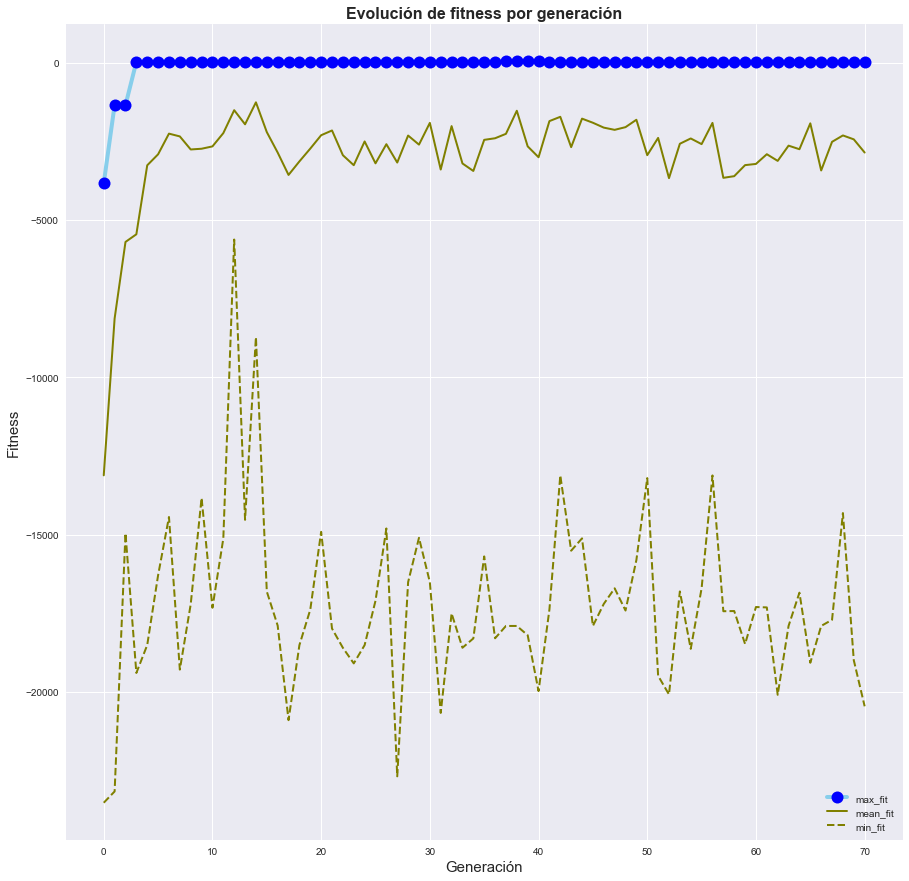

In [99]:
fig= plt.figure(figsize=(15,15))
plt.plot( x,  max_fit, marker='o', markerfacecolor='blue', markersize=12, color='skyblue', linewidth=4,label='max_fit')
plt.plot( x,  mean_fit, marker='', color='olive', linewidth=2,label='mean_fit')
plt.plot( x,  min_fit, marker='', color='olive', linewidth=2, linestyle='dashed', label='min_fit')
plt.title("Evolución de fitness por generación", fontsize=16, fontweight='bold')
#plt.suptitle("Random Walk Suptitle", fontsize=10)
plt.xlabel("Generación", fontsize=15)
plt.ylabel("Fitness", fontsize=15)
plt.legend()
plt.savefig('Images\Fitness_por_Generacion.png')
plt.show()


In [74]:
mut_rates = [i/10 for i in range(11)]
mut_rates

[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

In [62]:
# Prueba ejercicio 3
pesos = [12,2,1,1,4]
valores = [4,2,2,1,10]
capacidad = 15
castigo = 100
fit_params ={'pesos':pesos, 'valores':valores, 'capacidad':capacidad, 'castigo':castigo}
pop_sizes = [50*i for i in range(1,21)]
mut_rates = [i/10 for i in range(11)]
fit_fn = fitness_ex3 
cr_genes = gene_factory_ex3
cr_indv = indv_factory
term_cond = {'max_fitness':36, 'iters':70} 
indv_chars = {}
for i in range(len(pesos)):
    aux_dict = {}
    aux_dict['gene_type'] = int
    aux_dict['fact_range'] = [0,15]
    indv_chars[i] = aux_dict.copy()
res = []
for rt in mut_rates:    
    mut_rate = rt
    res_rt = []
    for item in pop_sizes:
        pop_sz_0 = item
        GA = GENALG(pop_sz_0, fit_fn, cr_genes, cr_indv, mut_rate, term_cond, indv_chars)
        slots=5
        generations, goal_cross, overall_max_fitness, overall_fittest_indv = GA.apply(fit_params, slots)
        res_rt.append(goal_cross)
    res.append(res_rt[:])

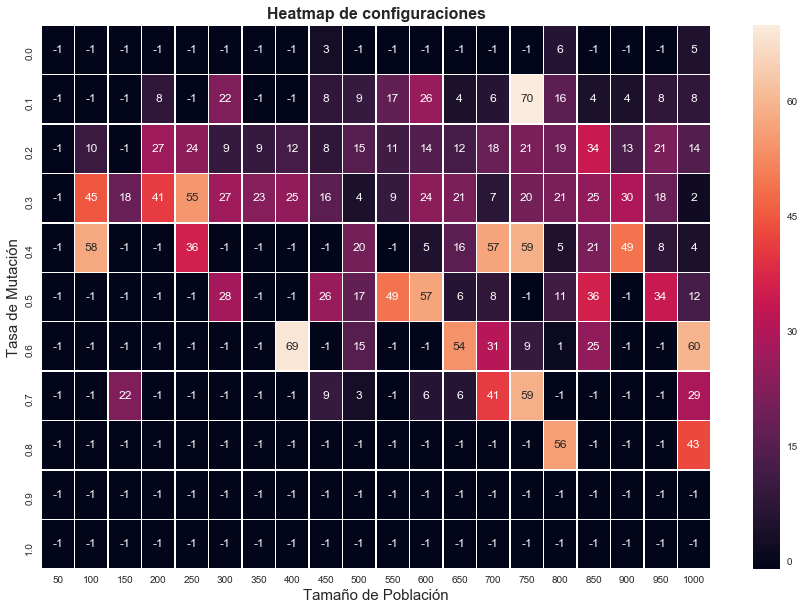

In [97]:
import seaborn as sns
sns.set()
fig = plt.figure(figsize=(15,10))
ax = sns.heatmap(data, annot=True, fmt="d",linewidths=.5, xticklabels =pop_sizes, yticklabels=mut_rates)
plt.title("Heatmap de configuraciones", fontsize=16, fontweight='bold')
plt.xlabel("Tamaño de Población", fontsize=15)
plt.ylabel("Tasa de Mutación", fontsize=15)
plt.savefig('Images\Heatmap.png')
plt.show()

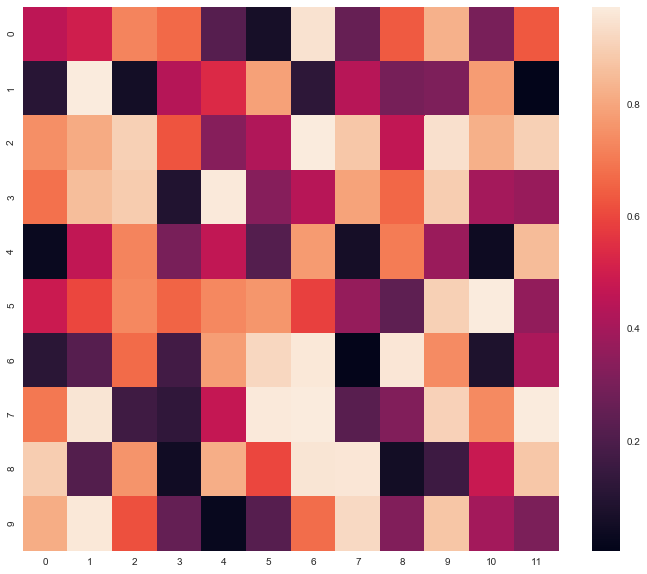

In [55]:

uniform_data = np.random.rand(10, 12)
fig = plt.figure(figsize=(12,10))
ax = sns.heatmap(uniform_data)
plt.show()

In [63]:
data = np.array(res)

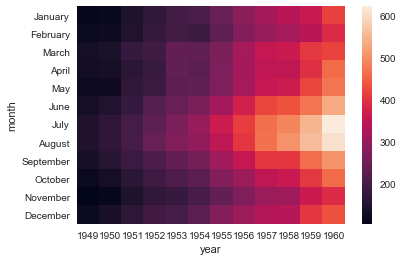

In [68]:
flights = sns.load_dataset("flights")
flights = flights.pivot("month", "year", "passengers")
ax = sns.heatmap(flights)
plt.show()

In [69]:
flights

year,1949,1950,1951,1952,1953,1954,1955,1956,1957,1958,1959,1960
month,,,,,,,,,,,,
January,112,115,145,171,196,204,242,284,315,340,360,417
February,118,126,150,180,196,188,233,277,301,318,342,391
March,132,141,178,193,236,235,267,317,356,362,406,419
April,129,135,163,181,235,227,269,313,348,348,396,461
May,121,125,172,183,229,234,270,318,355,363,420,472
June,135,149,178,218,243,264,315,374,422,435,472,535
July,148,170,199,230,264,302,364,413,465,491,548,622
August,148,170,199,242,272,293,347,405,467,505,559,606
September,136,158,184,209,237,259,312,355,404,404,463,508


In [57]:
pop_sizes = [50*i for i in range(1,21)]
mut_rates = [0.1* i for i in range(11)]

In [60]:
pop_sizes[-1]

1000

In [ ]:
def gene_factory(gene_type, fact_range=None):
    if type(fact_range) is not list:
            raise ValueError("Debe entregar una lista con el rango de valores factible")
    else:
        if gene_type == int: 
            new_gene = np.random.randint(fact_range[0], fact_range[1]+1)
            return new_gene
        elif gene_type == str:
            new_gene = np.random.choice(fact_range)
            return new_gene
        elif gene_type == 'binary':
            new_gene = np.random.choice(fact_range)
            return new_gene
        elif gene_type == float:
            new_gene = np.random.rand() * (fact_range[1] - fact_range[0]) + fact_range[0]
            return new_gene
        
   

In [ ]:
import numpy as np
np.random.seed(0)
def f_1():
    return np.random.rand()

In [ ]:
f_1()

In [ ]:
f_1()

In [23]:
type(1)==int

True

<function bin>

In [ ]:
a = None

In [ ]:
a is None

In [ ]:
np.inf

In [ ]:
3>-np.inf

In [ ]:
np.random.randint(0, 100,5)

In [ ]:
a= {0:10,1:20}

In [ ]:
list(a.values())


In [4]:
import numpy as np

In [ ]:
np.random.rand()

In [1]:
a=[1,2,3,4]
b=[1,2,3,4]

In [6]:
np.dot(a,b)

30

In [ ]:
np.mean(a)

In [3]:
type(a) is list

True

In [6]:
np.random.choice([0,1])

1

In [7]:
np.random.choice([0,1])

1

In [8]:
np.random.choice([0,1])

1

In [9]:
np.random.choice([0,1])

0

In [10]:
np.random.choice([0,1])

1

In [11]:
np.random.choice([0,1])

0

In [19]:
a ='abcdefghijklmnñopqrstuvwxyzABCDEFGHIJKLMNÑOPQRSTUVWXYZ '
b = list(a)


In [20]:
b

['a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'j',
 'k',
 'l',
 'm',
 'n',
 'ñ',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'x',
 'y',
 'z',
 'A',
 'B',
 'C',
 'D',
 'E',
 'F',
 'G',
 'H',
 'I',
 'J',
 'K',
 'L',
 'M',
 'N',
 'Ñ',
 'O',
 'P',
 'Q',
 'R',
 'S',
 'T',
 'U',
 'V',
 'W',
 'X',
 'Y',
 'Z',
 ' ']

In [15]:
list(a)

['a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'j',
 'k',
 'l',
 'm',
 'n',
 'ñ',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'x',
 'y',
 'z',
 'A',
 'B',
 'C',
 'D',
 'E',
 'F',
 'G',
 'H',
 'I',
 'J',
 'K',
 'L',
 'M',
 'N',
 'Ñ',
 'O',
 'P',
 'Q',
 'R',
 'S',
 'T',
 'U',
 'V',
 'W',
 'X',
 'Y',
 'Z']

In [22]:
np.random.choice('cat')

ValueError: a must be 1-dimensional or an integer

In [28]:
a =[0,1,1,0,1,1,1]

In [29]:
b = ''.join(str(i) for i in a)

In [30]:
b

'0110111'

In [31]:
int(b, 2)

55

In [13]:
# Random Maze Generator using Depth-first Search
# http://en.wikipedia.org/wiki/Maze_generation_algorithm
# FB36 - 20130106
import random
from PIL import Image
imgx = 500; imgy = 500
image = Image.new("RGB", (imgx, imgy))
pixels = image.load()
mx = 100; my = 100 # width and height of the maze
maze = [[0 for x in range(mx)] for y in range(my)]
dx = [0, 1, 0, -1]; dy = [-1, 0, 1, 0] # 4 directions to move in the maze
color = [(0, 0, 0), (255, 255, 255)] # RGB colors of the maze
# start the maze from a random cell
cx = int(random.randint(0, mx - 1)); cy = int(random.randint(0, my - 1))
maze[cy][cx] = 1; stack = [(cx, cy, 0)] # stack element: (x, y, direction)

while len(stack) > 0:
    (cx, cy, cd) = stack[-1]
    # to prevent zigzags:
    # if changed direction in the last move then cannot change again
    if len(stack) > 2:
        if cd != stack[-2][2]: dirRange = [cd]
        else: dirRange = range(4)
    else: dirRange = range(4)

    # find a new cell to add
    nlst = [] # list of available neighbors
    for i in dirRange:
        nx = cx + dx[i]; ny = cy + dy[i]
        if nx >= 0 and nx < mx and ny >= 0 and ny < my:
            if maze[ny][nx] == 0:
                ctr = 0 # of occupied neighbors must be 1
                for j in range(4):
                    ex = nx + dx[j]; ey = ny + dy[j]
                    if ex >= 0 and ex < mx and ey >= 0 and ey < my:
                        if maze[ey][ex] == 1: ctr += 1
                if ctr == 1: nlst.append(i)

    # if 1 or more neighbors available then randomly select one and move
    if len(nlst) > 0:
        ir = nlst[random.randint(0, len(nlst) - 1)]
        cx += dx[ir]; cy += dy[ir]; maze[cy][cx] = 1
        stack.append((cx, cy, ir))
    else: stack.pop()

# paint the maze
for ky in range(imgy):
    for kx in range(imgx):
        pixels[int(kx), int(ky)] = color[maze[my * ky / imgy][mx * kx / imgx]]
image.save("Maze_" + str(mx) + "x" + str(my) + ".png", "PNG")

TypeError: list indices must be integers or slices, not float

In [76]:
a = None

In [80]:
a  != None

False

In [91]:
a =[10,13,7,9, 13]

In [92]:
b = sorted(a, reverse=True)

In [93]:
b

[13, 13, 10, 9, 7]

In [94]:
c=[1,2,3,4,5]

In [95]:
b.pop(0)

13

In [ ]:
c.pop

In [96]:
b

[13, 10, 9, 7]

In [ ]:
# Prueba ejercicio 3
pesos = [12,2,1,1,4]
valores = [4,2,2,1,10]
capacidad = 15
castigo = 100
fit_params ={'pesos':pesos, 'valores':valores, 'capacidad':capacidad, 'castigo':castigo}
pop_sizes = [50*i for i in range(1,21)]
mut_rates = [i/10 for i in range(11)]
fit_fn = fitness_ex3 
cr_genes = gene_factory_ex3
cr_indv = indv_factory
term_cond = {'max_fitness':36, 'iters':70} 
indv_chars = {}
for i in range(len(pesos)):
    aux_dict = {}
    aux_dict['gene_type'] = int
    aux_dict['fact_range'] = [0,15]
    indv_chars[i] = aux_dict.copy()
res = []
for rt in mut_rates:    
    mut_rate = rt
    res_rt = []
    for item in pop_sizes:
        pop_sz_0 = item
        GA = GENALG(pop_sz_0, fit_fn, cr_genes, cr_indv, mut_rate, term_cond, indv_chars)
        slots=5
        generations, goal_cross, overall_max_fitness, overall_fittest_indv = GA.apply(fit_params, slots)
        res_rt.append(goal_cross)
    res.append(res_rt[:])